In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import Prophet, ARIMA, RNNModel, RandomForest, RegressionModel, LinearRegressionModel
import darts.metrics as metrics
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics
import seaborn as sns

## 1. Load data as a darts TimeSeries

In [137]:
df = pd.read_pickle("data.pkl")
df.index = pd.to_datetime(df.index, format='%Y')

label_encoder = LabelEncoder()
df['cocnumber'] = label_encoder.fit_transform(df['cocnumber'])

selected_covariates = ['hou_mkt_rentvacancy_xt', 'hou_mkt_ovrcrowd_xt',
    'hou_mkt_pctoverhouse_psh_hud', 'hou_mkt_evict_rate',
    'hou_pol_eli_psh_hud','d_hou_pol_hudunit_psh_hud_share',
    'd_hou_pol_occhudunit_psh_hud', 'hou_pol_fedfundcoc',  
    'econ_labor_unemp_rate_BLS', 'econ_labor_incineq_xt', 
    'econ_sn_cashasst_xt', 'sub_high_cost_homeval75',
    'sub_high_rent_share75', 'tight_high_cost_rental_mkt',
    'sub_tight_high_cost_rent','suburban',
    'Mortality_Rank', 'Morbidity_Rank', 'Health_Behaviors_Rank',
    'Clinical_Care_Rank','Social_&_Economic_Factors_Rank', 
    'Physical_Environment_Rank', 'd_hou_mkt_burden_sev_rent_xt', 
    'dem_soc_ed_lesshs_xt','dem_pop_female_census_share',
    'dem_pop_mig_census_share', 'dem_soc_singparent_xt', 'dem_soc_vet_xt']

final_cols = ['cocnumber', 'pit_tot_hless_pit_hud']
final_cols.extend(selected_covariates)

df = df[final_cols]
display(df[df['cocnumber'] == 0])

,cocnumber,pit_tot_hless_pit_hud,hou_mkt_rentvacancy_xt,hou_mkt_ovrcrowd_xt,hou_mkt_pctoverhouse_psh_hud,hou_mkt_evict_rate,hou_pol_eli_psh_hud,d_hou_pol_hudunit_psh_hud_share,d_hou_pol_occhudunit_psh_hud,hou_pol_fedfundcoc,...,Health_Behaviors_Rank,Clinical_Care_Rank,Social_&_Economic_Factors_Rank,Physical_Environment_Rank,d_hou_mkt_burden_sev_rent_xt,dem_soc_ed_lesshs_xt,dem_pop_female_census_share,dem_pop_mig_census_share,dem_soc_singparent_xt,dem_soc_vet_xt
year,,,,,,,,,,,,,,,,,,,,,
2010-01-01,0,212.0,6.315952,1.891332,10.0,3.05,74.0,-0.249382,-1.010808,8.84256,...,29.0,27.0,5.0,70.0,-1.262639,8.814938,49.970783,-0.052773,24.139337,10.172604
2011-01-01,0,182.0,7.026713,1.541145,10.0,3.11,74.0,-0.319067,-5.000000,8.84256,...,16.0,50.0,7.0,11.0,-3.322617,6.816218,50.157089,0.017149,14.119467,9.161098
2012-01-01,0,196.0,4.374162,1.672888,10.0,2.91,76.0,-0.319067,-5.000000,9.10018,...,4.0,29.0,7.0,60.0,-3.322617,6.494505,50.214504,-0.705931,13.415127,7.541328
2013-01-01,0,185.0,7.026713,1.541145,10.0,2.83,76.0,-0.319067,-5.000000,9.00825,...,5.0,17.0,7.0,25.0,-3.322617,6.816218,50.183338,-0.541909,14.119467,9.161098
2014-01-01,0,166.0,4.374162,1.672888,9.0,2.37,70.0,-0.319067,-5.000000,8.83565,...,6.0,23.0,6.0,97.0,-3.322617,6.494505,50.209843,-0.572809,13.415127,7.541328
2015-01-01,0,177.0,4.374162,1.672888,9.0,0.00,72.0,-0.319067,-5.000000,9.21227,...,10.0,21.0,6.0,99.0,-3.322617,6.494505,50.170212,-0.406106,13.415127,7.541328
2016-01-01,0,154.0,4.374162,1.672888,8.0,0.00,73.0,-0.319067,-5.000000,9.30933,...,14.0,19.0,6.0,101.0,-3.322617,6.494505,50.194828,-0.279582,13.415127,7.541328
2017-01-01,0,155.0,4.374162,1.672888,9.0,0.00,74.0,-0.319067,-5.000000,9.75924,...,3.0,24.0,7.0,94.0,-3.322617,6.494505,50.227619,-0.407829,13.415127,7.541328


In [3]:
# Turn df into a list of time series (one for each CoC)
cols = list(df.columns)
cols.remove('cocnumber')
series_group = TimeSeries.from_group_dataframe(df, group_cols="cocnumber", value_cols=cols)

In [42]:
# Create a test/evaluation df with one-year future values for each CoC (no covariates)
full_pit_data = pd.read_excel("data/2007-2023-PIT-Counts-by-CoC.xlsx", sheet_name="2018")
full_pit_data.dropna(inplace=True)
full_pit_data = full_pit_data[full_pit_data['CoC Number'].str.contains("IL")]
full_pit_data = full_pit_data[["CoC Number", "Overall Homeless"]].reset_index(drop=True)
full_pit_data["CoC Number"] = label_encoder.fit_transform(full_pit_data["CoC Number"])

# Use the same preprocessing as normal df 
def replace_outliers_with_iqr(df, col):
    # Calculate quartiles
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    # Calculate IQR
    iqr = q3 - q1
    # Define lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # Replace outliers with corresponding IQR values
    df[col] = df[col].apply(lambda x: x if lower_bound <= x <= upper_bound else q1 if x < lower_bound else q3)
    return df

full_pit_data = replace_outliers_with_iqr(full_pit_data, "Overall Homeless")
test_set = full_pit_data["Overall Homeless"]

0     179.0
1     356.0
2     277.0
3     188.0
4     146.0
5     341.0
6     400.0
7     250.0
8     371.5
9     371.5
10    387.0
11    271.0
12    295.0
13     92.0
14    161.0
15    430.0
16    198.0
17     67.0
18    282.0
Name: Overall Homeless, dtype: float64

## 2. Create time-series models for each CoC

### Facebook Prophet

16:03:15 - cmdstanpy - INFO - Chain [1] start processing


16:03:15 - cmdstanpy - INFO - Chain [1] done processing
16:03:15 - cmdstanpy - INFO - Chain [1] start processing
16:03:15 - cmdstanpy - INFO - Chain [1] done processing
16:03:15 - cmdstanpy - INFO - Chain [1] start processing
16:03:15 - cmdstanpy - INFO - Chain [1] done processing
16:03:15 - cmdstanpy - INFO - Chain [1] start processing
16:03:15 - cmdstanpy - INFO - Chain [1] done processing
16:03:15 - cmdstanpy - INFO - Chain [1] start processing
16:03:15 - cmdstanpy - INFO - Chain [1] done processing
16:03:15 - cmdstanpy - INFO - Chain [1] start processing
16:03:16 - cmdstanpy - INFO - Chain [1] done processing
16:03:16 - cmdstanpy - INFO - Chain [1] start processing
16:03:16 - cmdstanpy - INFO - Chain [1] done processing
16:03:16 - cmdstanpy - INFO - Chain [1] start processing
16:03:16 - cmdstanpy - INFO - Chain [1] done processing
16:03:16 - cmdstanpy - INFO - Chain [1] start processing
16:03:16 - cmdstanpy - INFO - Chain [1] done processing
16:03:16 - cmdstanpy - INFO - Chain [1] 

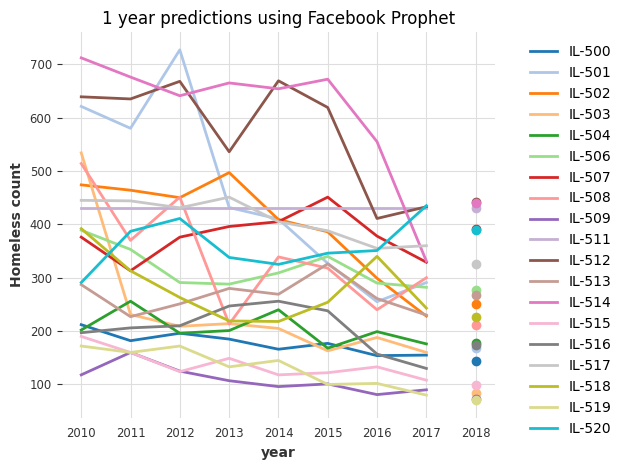

In [149]:
models = []
forecasts = []

count = 0
palette = sns.color_palette("tab20")  # Generate 15 distinct colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for ts in series_group:
    target = ts['pit_tot_hless_pit_hud']
    covariates = ts[selected_covariates]
    
    model = Prophet()
    model.fit(series=target)

    models.append(model)

    forecast = model.predict(n=1)
    forecasts.append(forecast)

    color = color_cycle[count % len(color_cycle)]
    target.plot(label=label_encoder.inverse_transform([count])[0], color=color)
    forecast.plot(label='_', ls=':', color=color)

    count += 1

plt.title("1 year predictions using Facebook Prophet")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel("Homeless count")
plt.tight_layout()
plt.show()

In [150]:
# Evaluate

forecast_array = np.array([forecast.values()[0][0] for forecast in forecasts])
smape = sklearn.metrics.mean_absolute_percentage_error(test_set, forecast_array)
print(smape)

0.23867738545294193


### Random Forest

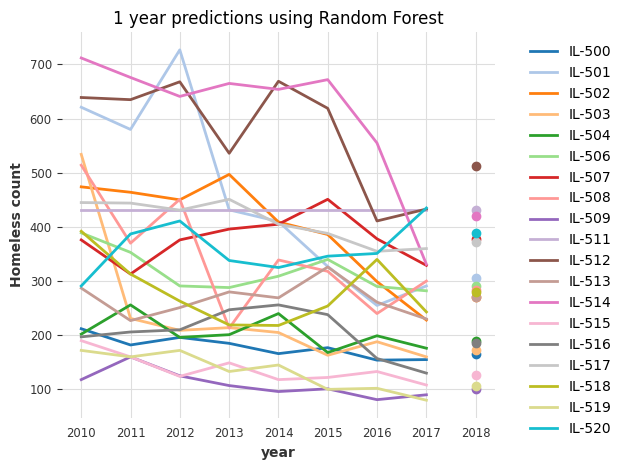

In [156]:
models = []
forecasts = []

count = 0
palette = sns.color_palette("tab20")  # Generate 15 distinct colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for ts in series_group:
    target = ts['pit_tot_hless_pit_hud']
    covariates = ts[selected_covariates]
    
    model = RandomForest(lags_past_covariates=1, n_estimators=50, output_chunk_length=1)
    model.fit(series=target, past_covariates=covariates)

    models.append(model)

    forecast = model.predict(n=1)
    forecasts.append(forecast)

    color = color_cycle[count % len(color_cycle)]
    target.plot(label=label_encoder.inverse_transform([count])[0], color=color)
    forecast.plot(label='_', ls='--', color=color)

    count += 1

plt.title("1 year predictions using Random Forest")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel("Homeless count")
plt.tight_layout()
plt.show()

In [152]:
# Evaluate
forecast_array = np.array([forecast.values()[0][0] for forecast in forecasts])
smape = sklearn.metrics.mean_absolute_percentage_error(test_set, forecast_array)
print(smape)

0.2390918999060048


### Regression

In [153]:
from sklearn.linear_model import Ridge, Lasso, LogisticRegression

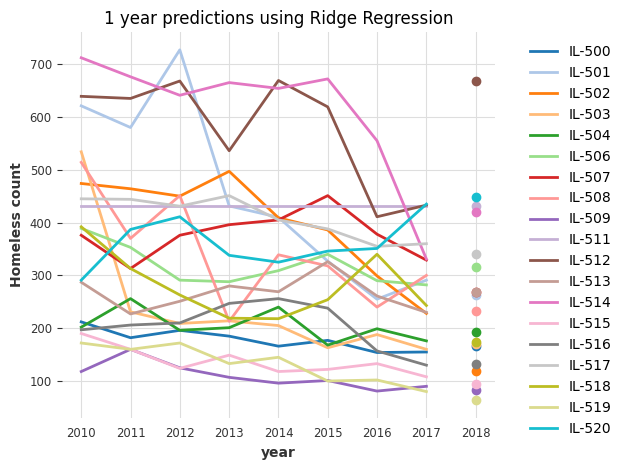

In [157]:
models = []
forecasts = []

count = 0
palette = sns.color_palette("tab20")  # Generate 20 distinct colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for ts in series_group:
    target = ts['pit_tot_hless_pit_hud']
    covariates = ts[selected_covariates]
    
    model = RegressionModel(model=Ridge(alpha=0.8), lags=1, lags_past_covariates=1)
    model.fit(series=target, past_covariates=covariates)

    models.append(model)
    
    forecast = model.predict(n=1)
    forecasts.append(forecast)

    color = color_cycle[count % len(color_cycle)]
    target.plot(label=label_encoder.inverse_transform([count])[0], color=color)
    forecast.plot(label='_', ls='--', color=color)

    count += 1

plt.title("1 year predictions using Ridge Regression")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel("Homeless count")
plt.tight_layout()
plt.show()

In [155]:
# Evaluate
forecast_array = np.array([forecast.values()[0][0] for forecast in forecasts])
smape = sklearn.metrics.mean_absolute_percentage_error(test_set, forecast_array)
print(smape)

0.2660481168251188
